# <center> A/B-тестирование гипотез интернет-магазина

Отделы маркетинга и аналитики в крупном интернет-магазине подготовили некотрые гипотезы для увеличения выручки. Непосредственно, проведем A/B-тестирование различий в среднем количестве заказов и средней сумме чека по группам. Подготовительным этапом будет служить загрузка и подготовка данных, после чего будет произведена приоритизация гипотез. По завершению этапа подготовки данных, приступим к анализу A/B-теста: пострение графиков по группам, расчет перцентилей и проведение статистическо теста. 

### Загрузка данных

In [1]:
#подключаем библиотеки, необходимые для работы
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
#выгружаем таблицы
hypothesis, orders, visitors = (pd.read_csv('/datasets/hypothesis.csv'),
                               pd.read_csv('/datasets/orders.csv'),
                               pd.read_csv('/datasets/visitors.csv'))

#выводим первые 5 строк датафреймов для ознакомления
display(hypothesis.head(5), orders.head(5), visitors.head(5))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [3]:
#приводим название столбцов таблицы "hypothesis" к нижнему регистру и "orders" к "змеиному регистру"
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(
    columns={'transactionId' : 'transaction_id',
             'visitorId' : 'visitor_id'})

In [4]:
#получаем информацию о таблицах
print('Информация о таблице с гипотезами', hypothesis.info())
print()
print('Информация о таблице с заказами', orders.info())
print()
print('Информация о таблице с группами А/В-теста', visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Информация о таблице с гипотезами None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Информация о таблице с заказами None

<class 'pandas.core.fr

По информации, полученной о таблицах видно, что в данных отсутствуют пропуски, а большинство столбцом имеют необходимый формат, кроме даты. Следующим этапом - приводим дату в нужный формат.

In [5]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

In [6]:
#считаем количество дубликатов в таблицах
print('Количество дубликатов в таблице hypothesis:', hypothesis.duplicated().sum())
print('Количество дубликатов в таблице orders:', orders.duplicated().sum())
print('Количество дубликатов в таблице visitors:', visitors.duplicated().sum())

Количество дубликатов в таблице hypothesis: 0
Количество дубликатов в таблице orders: 0
Количество дубликатов в таблице visitors: 0


Дубликаты в таблицах отсутствуют, однако, имеется вероятность попадания некоторых пользователей как в группу А, так в группу В. Проверим уникальные visitor_id в группах анализа.

In [7]:
#создаем список уникальных visitor_id для каждой группы тестирования
a_users = set(orders.query('group == "A"')['visitor_id'])
b_users = set(orders.query('group == "B"')['visitor_id'])
#находим общих пользователей для двух групп
common_id = a_users.intersection(b_users)
print('Количество пользователей, попавших в обе группы:', len(common_id))

Количество пользователей, попавших в обе группы: 58


Итак, по результатам проверки выявлено 58 visitor_id, входящих в обе группы наблюдей. Для минимизации дальнейшего искажения результатов анализа удалим данных пользователей из общей выборки.

In [8]:
orders = orders.query('visitor_id not in @common_id')

Таким образом, на этапе предобработки данных выгружены таблицы, даты приведены в нужный формат для работы, название некоторых столбцов изменены на соответствие "змеиному регистру". Пропуски и дубликаты в значениях обнаружены не были, однако, по результатам проверки пользователей, попавших в группы анализа, выявлено 58 visitor_id, которые были как в группе А, так в группе В. В качестве недопущения искажения данных при дальнейшем анализе, данные пользователи были удалены из таблицы.

### Приоритизация гипотез

Проведем приоритизацию гипотез. Данный пункт необходимо выполнить, поскольку приоритизация выполнения гипотез решает множество задач: эффективное использование ресурсов (материальных, а также человеко-часов), улучщение результатов, снижения риска потерь, а также оптимизацию тестирования. Основными методами приоритизации гипотез являются: ICE (Impact, Confidence, Ease) и RICE (Reach, Impact, Confidence, Effort). Оба метода помогают определить, на какие задачи следует направить ресурсы в первую очередь, но используют разные критерии для оценки приоритетности. RICE является более детализированным и учитывает охват пользователей, а ICE проще и может быть более удобным для быстрых оценок при условии отсутствия фокуса на охвате. 

Для приоритизации наших гипотез рассчитаем как ICE, так и  RICE.

In [9]:
#рассчет ICE
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
print(hypothesis[['hypothesis','ICE']].sort_values('ICE', ascending=False))
print()
#рассчет RICE
hypothesis['RICE'] = (hypothesis['impact'] * hypothesis['confidence'] * hypothesis['reach']) / hypothesis['efforts']
print(hypothesis[['hypothesis','RICE']].sort_values('RICE', ascending=False))

                                          hypothesis        ICE
8  Запустить акцию, дающую скидку на товар в день...  16.200000
0  Добавить два новых канала привлечения трафика,...  13.333333
7  Добавить форму подписки на все основные страни...  11.200000
6  Показать на главной странице баннеры с актуаль...   8.000000
2  Добавить блоки рекомендаций товаров на сайт ин...   7.000000
1  Запустить собственную службу доставки, что сок...   2.000000
5  Добавить страницу отзывов клиентов о магазине,...   1.333333
3  Изменить структура категорий, что увеличит кон...   1.125000
4  Изменить цвет фона главной страницы, чтобы уве...   1.000000

                                          hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2

In [10]:
print('Топ-3 приоритетные гипотезы согласно ICE:', '\n'.join(hypothesis.loc[[8, 0, 7], 'hypothesis']))
print()
print('Топ-3 приоритетные гипотезы согласно RICE:', '\n'.join(hypothesis.loc[[7, 2, 0], 'hypothesis']))

Топ-3 приоритетные гипотезы согласно ICE: Запустить акцию, дающую скидку на товар в день рождения
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Топ-3 приоритетные гипотезы согласно RICE: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей


Методы приоритизации ICE и RICE выделили две одинаковые гипотезы: добавление новых каналов трафика, а также добавление формы подписки на все основные страницы. Касательно уникальных приоритетов для этих методов: ICE выделил гипотезу о запуске акции с скидками на день рождения, а RICE выделил гипотезу о добавлении блоков рекомендаций товаров. 

Использование двух методов приоритизации гипотез позволяет выделить как гипотезы с быстрыми результатами, так и гипотезы с долгосрочным влиянием. Использование обоих методов позволит подойти к приоритизайии более сбалансированно.



### Анализ A/B-теста

#### Анализ кумулятивных метрик

Приступим к анализу кумулятивных метрик. Для начала "соберем" таблицу, на основе которой будем строить кумулятивные графики.

In [11]:
#создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

#получаем агрегированные кумулятивные данные о заказах
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])
    ].agg({
        'date': 'max',
        'group': 'max',
        'transaction_id': 'nunique',
        'visitor_id': 'nunique',
        'revenue': 'sum'
    }), 
    axis=1
).sort_values(by=['date', 'group'])

#и о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])
    ].agg({
        'date': 'max',
        'group': 'max',
        'visitors': 'sum'
    }), 
    axis=1
).sort_values(by=['date', 'group'])

#создаем обобщенный датафрейм с кумулятивными данными
cumulativeData = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))



        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


Теперь в таблице cumulativeData хранятся все данные, необходимые для последующего анализа. Построим график кумулятивной выручки по группам.

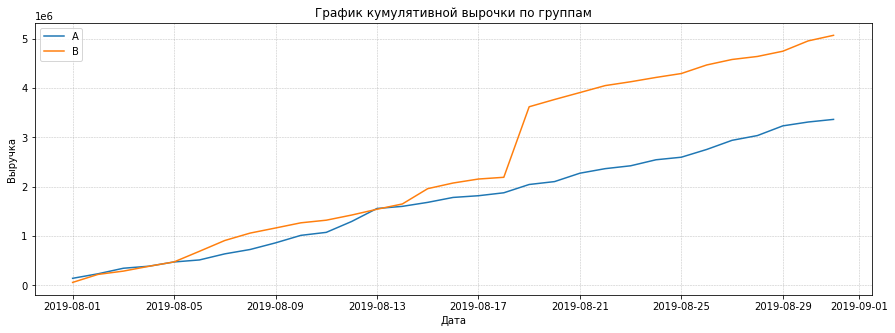

In [12]:
#таблица с  кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
#таблица с  кумулятивным количеством заказов и кумулятивной выручкой по дням в группе В
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
#построение графика
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
#задаем параметры и оформление графика
plt.title('График кумулятивной вырочки по группам')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

Группа А показывает плавное увеличение кумулятивной выручки, в то время как группа В имеет резкий подъем 19 августа. Возможно, это связано с наличием "выброса" - особо крупной покупке, совершенной пользователем, находящейся в группе В. Далее, рассмотрим график кумулятивного среднего чека по группам.

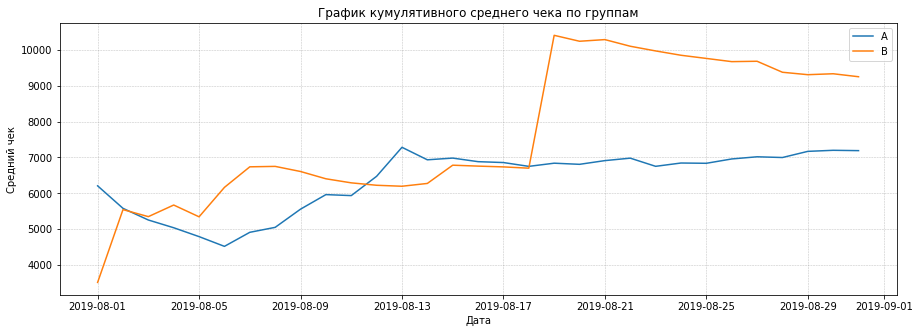

In [13]:
#построение графика кумулятивного среднего чека по группам
plt.figure(figsize=(15, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
#задаем параметры и оформление графика
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

Рассмотрим кумулятивный средний чек у группы А: в начале периода наблюдается снижение среднего чека, однако, начиная с 6 августа происходит постепенный рост с незначительным повторным снижением 14 августа, затем средний чек остается относительно стабильным с середины периода и до конца.

В группе В мы можем наблюдать резкое увеличение суммы среднего чека в начале периода, затем состояние стабилизируется. Однако, в середине рассматриваемого периода наблюдаем резкий скачок среднего чека, что также косвенно может подтверждать теорию о наличии выброса. 

Таким образом, средний чек группы В на протяжении первой половины изучаемого периода остается выше среднего чека группы А, но в середине периода, из-за резкого увеличения среднего чека, разрыв между группами становится более значительным. 

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

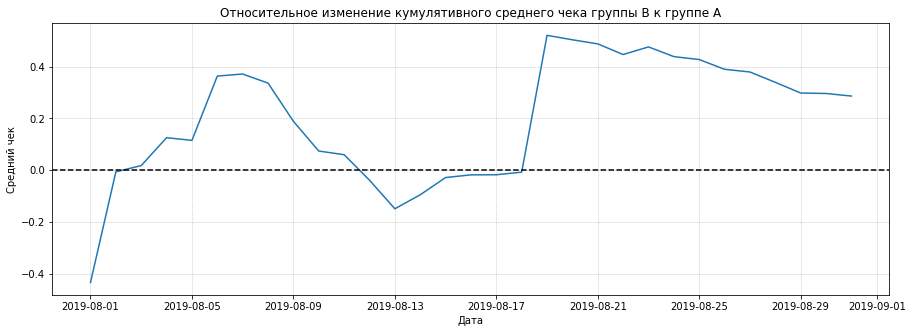

In [14]:
#объединяем кумулятивные данны группы А и группы В и один датафрейм
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
#строим график относительно различия кумулятивного среднего чека группы B к группе A
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
#задаем параметры и оформление графика
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--');

В начале периода можем наблюдать отрицательное отклонение среднего чека группы B по сравнению с группой A. Далее, график отображает значительные колебания - в некоторые моменты средний чек группы B превышает средний чек группы A в несколько раз, с колебанием в отрицательные значения (уменьшение среднего чека группы В относительно группы А). В середине графика заметен резкий скачок в положительную сторону, за которым следует падение, которое предполагает наличие выброса в районе 18 августа.

Построим график кумулятивного среднего количества заказов на посетителя по группам.

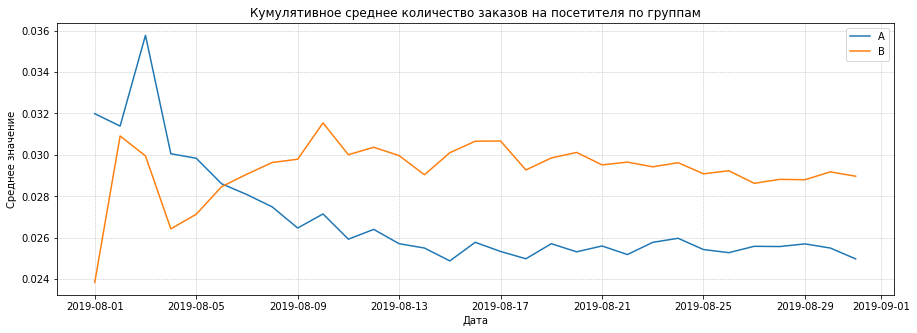

In [15]:
#рассчет среднего количества заказов на пользователя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
#для группы А
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
#для группы В
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
#построение графика среднего количество заказов на посетителя по группам
plt.figure(figsize=(15, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
#задаем параметры и оформление графика
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Среднее значение')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)

В начале рассматриваемого периода можем наблюдать значительные колебания среднего количества заказов на посетителя для обеих групп. Однако, с 4 августа ситуация в обоих группах немного стабилизируется: у группа А среднее количество заказов на посететиля по группам снижается, в то время как у группы В - увеличивается. 

Несмотря на начальные колебания, группа B демонстрирует более высокие значения по среднему количеству заказов на посетителя, что говорит о потенциально более выиграшной стратегии. 

Далее рассмотрим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

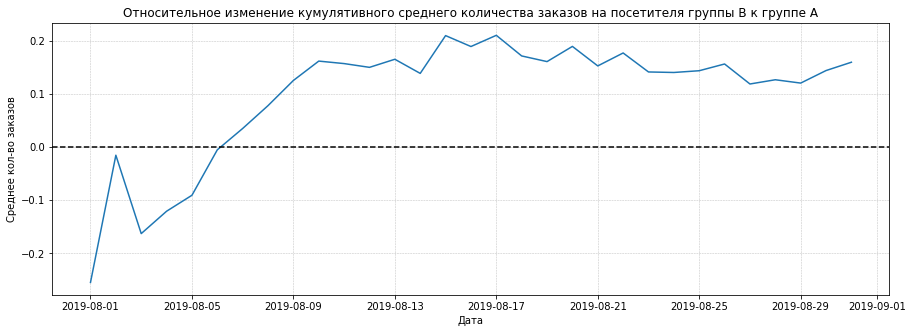

In [16]:
#объединяем данные для группы А и группы В
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
#построение графика
plt.figure(figsize=(15, 5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
#задаем параметры и оформление графика
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Среднее кол-во заказов')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--');

Несмотря на отрицательное отклонение среднего количества заказов группы В относительно группы А в начале рассматриваемого периода, график показывает, что в течение времени группа B смогла значительно улучшить свои показатели по среднему количеству заказов на посетителя относительно группы А. 


Выше мы построили и рассмотрели кумулятивные метрики - изменения среднего чека и среднего количества заказов по группам и отношения этих метрик группы В к группе А. 

Группа В по всем метрикам показывает лучшие результаты, однако, в середине наблюдаемого периода в группе В обнаружен выброс - аномально высокий заказ, который можно отследить на графиках среднего чека и выручки по группам. В связи с этим, делать вывод касательно успешности стратегии, применяемой к группе В, мы в полной мере не можем. Для корректной формулировки вывода об успешности стратегии В необходимо изучить стоимость заказов и количество покупок, далее по этим данным определить выбросы и провести статистический анализ как на сырых, так и на очищенных данных. 

#### Определение аномальных значений

На этапе определения аномальных значений в наших данных построим точечные графики количества заказов по пользователям и точечный график стоимости заказов. Для каждого из этих двух пунктов анализа дополнительно найдем 95 и 99 перцентили для установления границы анализа - какие данные мы исключим для максимальной точности проведения статистического теста. 

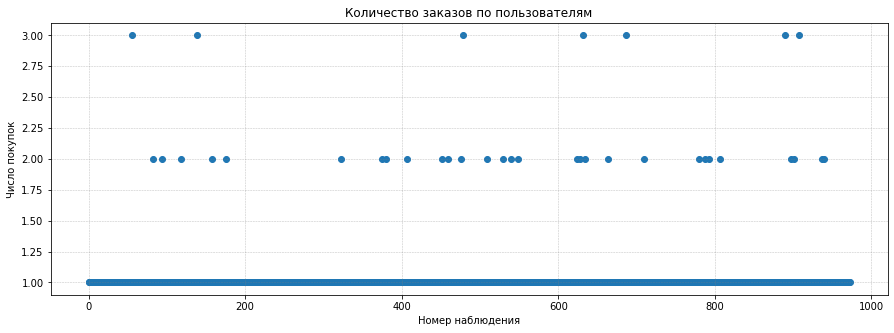

In [17]:
#создаем таблицу с уникальными заказами для пользователей
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']
#серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
#построение графика
plt.figure(figsize=(15, 5))
plt.scatter(x_values, ordersByUsers['orders'])
plt.xlabel('Номер наблюдения')
plt.ylabel('Число покупок')
plt.title('Количество заказов по пользователям')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)


На графике видно, что подавляющее большинство пользователей совершают только одну покупку. Намного меньше доходят до повторного заказа, а 3 заказа делают единицы. 

In [18]:
#рассчитаем 95-й и 99-й перцентили количества заказов на пользователя
print('95-й и 99-й перцентили количества заказов на пользователя:', np.percentile(ordersByUsers['orders'], [95, 99]))

95-й и 99-й перцентили количества заказов на пользователя: [1. 2.]


Мы определили, что 1% пользователей совершает более двух заказов. Будем считать это за границу количества заказов. Однако, для более полной картины изучит график и 95-й и 99-й перцентили стоимости заказов. 

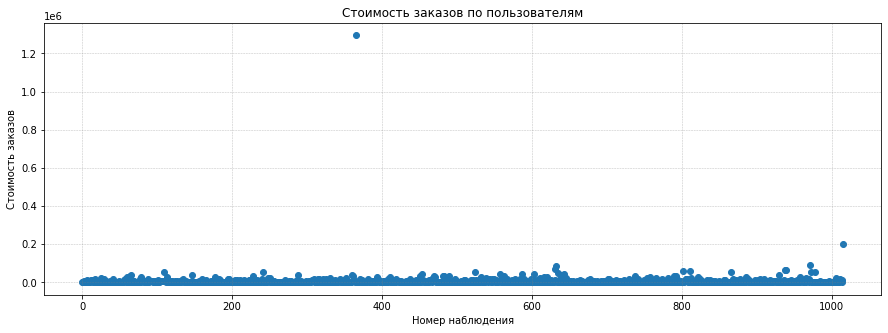

In [19]:
#строим точечный график стоимостей заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 5))
plt.scatter(x_values, orders['revenue'])
plt.xlabel('Номер наблюдения')
plt.ylabel('Стоимость заказов')
plt.title('Стоимость заказов по пользователям')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.5)


Практически все заказы назодятся в одном ценовом диапазоне. Однако, имеется один аномально дорогой заказ - свыше миллиона. Рассмотрим 95-й и 99-й перцентили

In [20]:
#рассчитаем 95-й и 99-й перцентили стоимости заказов
print('95-й и 99-й перцентили стоимости заказа:', np.percentile(orders['revenue'], [95, 99])) 

95-й и 99-й перцентили стоимости заказа: [26785. 53904.]


С учетом рассчета перцентилей стоимости заказа установим границы определения аномальных пользователей. Выбросами будем считать пользователя, совершившего более 2х заказов и пользователи с покупкой свыше 53904. 

#### Рассчет статистической значимости для "сырых данных"

Хоть мы и установили порог для выбросов, рассчитаем для начала статистическую значимость различий между группами по по «сырым» данным.

In [21]:
#подготовка данных для группы A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

#для группы B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

#подготовка данных о заказах для группы A
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

#для группы B
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

#объединим данные
data = (
    ordersADaily.merge(ordersBDaily, on='date', how='left')
    .merge(ordersACummulative, on='date', how='left')
    .merge(ordersBCummulative, on='date', how='left')
    .merge(visitorsADaily, on='date', how='left')
    .merge(visitorsBDaily, on='date', how='left')
    .merge(visitorsACummulative, on='date', how='left')
    .merge(visitorsBCummulative, on='date', how='left')
)




Выше мы провели фильтрацию данных, посчитали ежедневное и кумулятивное количество посетителей е и кумулятивное количество заказов и выручку для каждой группы, а также объединили в один датафрейм для удобства дальнейшего анализа.


In [22]:
display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Имея такой объединеный датафрейм переходим к подготовке данных для статистического теста - рассчет статистической значимости различий в среднем количестве заказов на посетителя между группами

In [23]:
#подготовка данных для статистического теста
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

#дополнение выборок нулями
sampleA = pd.concat([
    ordersByUsersA['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
], axis=0)

sampleB = pd.concat([
    ordersByUsersB['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')
], axis=0)

Формируем гипотезы. Нулевая гипотеза будет гласить: различия в среднем количестве заказов между группами отсутствуют. Альтернативная: различия в среднем количестве заказов между группами присутствуют.

Сравнивать группы между собой будем с помощью критерия Манна-Уитни, определив уровень значимости в 0.05.

In [24]:
#проводим статистический тест
u_stat, p_value = stats.mannwhitneyu(sampleA, sampleB)

#вычисляем относительное изменение среднего количества заказов
relative_change = sampleB.mean() / sampleA.mean() - 1

#задаем уровень значимости 
alpha = 0.05

print(f"p-value: {p_value:.5f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print(f'Относительное изменение среднего количества заказов: {relative_change:.3f}')

p-value: 0.01102
Отвергаем нулевую гипотезу
Относительное изменение среднего количества заказов: 0.160


Мы получили значение p-value равное 0.01102, что дает нам право отвергнуть нулевую гипотезу. Однако, поскольку данные "сырые" и имеют в своем массиве пользователей, которые мы признали аномальными, точно утверждать о наличии различий мы не можем. 

Рассмотрим статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сформулируем гипотезы. Нулевая гипотеза: различия в среднем чеке заказа между группами отсутствуют. Альтернативная: различия в среднем чеке заказа между группами присутствуют.

In [25]:
#статистический тест для среднего чека заказа между группами
p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
relative_change = orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1

print(f"p-value: {p_value:.5f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print(f"Относительное изменение среднего чека заказа: {relative_change:.3f}")


p-value: 0.82949
Не получилось отвергнуть нулевую гипотезу
Относительное изменение среднего чека заказа: 0.287


Также не получилось отвергнуть нулевую гипотезу об различии среднего чека заказа между группами. 
Однако, эти значения не истинные, поскольку данные "сырые". Проверим эти же гипотезы на очищенных данных.

#### Рассчет статистической значимости для очищенных данных

Для проведения более корректного статистического анализа проведем очистку наших данных от аномальных значений, установленных ранее.

In [26]:
#находим пользователей с заказами больше 2х
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)

#находим пользователей с заказами дороже 53904
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitor_id']

#объединяем их
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)


Фильтруем данные по количеству заказов по группам и формируем нулевую и альтернативыне гипотезы. Нулевая гипотеза: различия в среднем чеке заказа между группами отсутствуют. Альтернативная: различия в среднем чеке заказа между группами присутствуют.

In [27]:
#фильтруем данные для группы А
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#фильтруем данные для группы B
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#проводим статистический тест
p_value = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]
relative_change = sampleBFiltered.mean() / sampleAFiltered.mean() - 1

print(f"p-value: {p_value:.5f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print(f"Относительное изменение среднего количества заказов: {relative_change:.3f}")

p-value: 0.00702
Отвергаем нулевую гипотезу
Относительное изменение среднего количества заказов: 0.189


Относительное изменение среднего количества заказов показывает, что среднее количество заказов в группе B на 18.9% выше, чем в группе A.
Также, это является  статистически значимым различием (p-value<0.05), что позволяет нам сделать вывод, что группы действительно отличаются по количеству заказов на пользователя.
Значение p-value в случае с очищенными данными несколько меньше, чем у сырых, что говорит нам о еще более меньшей ошибки в вычислениях.

Рассмотрим статистическую значимость по среднему чеку междлу группами. Нулевая гипотеза: различия в среднем чеке заказа между группами отсутствуют. Альтернативная: различия в среднем чеке заказа между группами присутствуют.

In [28]:
filtered_A_revenue = orders[
    np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers))
    )
]['revenue']

filtered_B_revenue = orders[
    np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers))
    )
]['revenue']

p_value = stats.mannwhitneyu(filtered_A_revenue, filtered_B_revenue)[1]
relative_change = filtered_B_revenue.mean() / filtered_A_revenue.mean() - 1


# Вывод результатов теста и принятие/отклонение гипотезы
print(f"p-value: {p_value:.5f}")
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print(f"Относительное изменение среднего чека заказа: {relative_change:.3f}")

p-value: 0.78770
Не получилось отвергнуть нулевую гипотезу
Относительное изменение среднего чека заказа: -0.032


Исходя из значения p-value мы не можем отвергнуть нулевую гипотезу - нет статистически значимых различий в среднем чеке заказа между группами A и B. Относительное изменение среднего чека заказа также является незначительным. 

Таким образом, после очистки данных от выбросов было подтверждено статистически значимое различие в количестве заказов по группам - группа В сделала на 18.9% больше заказов, чем группа А. Однако, даже с учетом большего количества заказов группой В статистически значимых различий в средней сумме чека по группам выявлено не было. 


### Выводы

По исходным данным был проведен этап загрузки и предобработки — приведены названия некоторых столбцов к общепринятому регистру, исправлен формат даты, проведена проверка на наличие дубликатов, а также выявление пользователей, которые попали в обе группы анализа. Было обнаружено 58 пользователей, которые, во избежание дальнейшего некорректного анализа, были удалены из массива данных.

Следующим этапом стала приоритизация гипотез. Приоритизация происходила с помощью двух методов — ICE и RICE, что позволяет подойти к приоритизации более сбалансированно. Было выделено по топ-3 гипотезы у каждого метода — по две общих и одной уникальной. Общие гипотезы — добавление новых каналов трафика, а также добавление формы подписки на все основные страницы. Уникальные приоритеты: ICE выделил гипотезу о запуске акции с скидками на день рождения, а RICE выделил гипотезу о добавлении блоков рекомендаций товаров. Что касается выбора только одной гипотезы, с которой стоит начать проводить исследования — необходимо определить стратегическое направление кампании: хотим ли мы получить быстрый результат с наименьшим вовлечением пользователей (ICE), либо же охватить большую выборку (RICE).


Анализ A/B теста был разделен на несколько подэтапов:
- Анализ кумулятивных метрик;
- Определение аномальных значений;
- Расчет статистической значимости для "сырых" данных;
- Расчет статистической значимости для очищенных данных.

При анализе кумулятивных метрик был обнаружен выброс — аномально крупная покупка, совершенная 18 августа. Наличие такой покупки кардинально меняло поведение графика — после середины наблюдаемого периода группа B, в которой был обнаружен такой выброс, на несколько порядков увеличивала разрыв относительно кумулятивной выручки и среднего чека к группе A. Также, при анализе кумулятивных графиков среднего количества заказов по группам, группа B заметно лидировала, хотя в начале периода имела резкий подъем и спад, но затем смогла стабилизироваться в положительную динамику, в то время как группа A, имея такой же подъем и спад, но на более высоких показателях, не смогла сохранить высокий уровень и уменьшала свои показатели, оставив группу B в лидерах.

Определение аномальных значений проводилось с помощью точечных графиков количества заказов по пользователям, а также графика стоимости заказов. Обнаруженные выбросы подтверждались с помощью 95 и 99 перцентилей. Таким образом, был установлен порог "нормальности". Аномальными были признаны пользователи, совершившие более 2 заказов, а также купившие на сумму свыше 53904.

Не удаляя аномальных пользователей, был проведен статистический тест (Манна-Уитни) по двум критериям: различия в количестве заказов по группам и различия в среднем чеке по группам. По "сырым" данным различия в среднем чеке обнаружены не были, хоть и имелись аномально дорогие заказы. Однако, было обнаружено статистически значимое различие по количеству заказов по группам — группа B на 16% больше совершила покупок.

Далее, эти же гипотезы проверялись на очищенных данных: средний чек также не имеет статистически достоверных различий, а различие количества заказов по группам также подтвердилось с более низкой ошибкой (p-value = 0.00702) и 18.9% относительного изменения среднего количества заказов.

На основании проведенного анализа можно сделать вывод, что цель тестирования по выявлению различий в количестве заказов между группами достигнута. Группа B показала статистически значимое преимущество в количестве заказов. Тестирование касательно среднего чека в группах как по сырым данным, так и по очищенным не показало статистически достоверных результатов. В целях сохранения временных и финансовых затрат стоит завершить проведение тестирования. Внедрение стратегии, применяемой к группе,  в группу А потенциально сможет увеличить активность пользователей и их количество заказов, что, вероятно, в будущем сможет отразиться на среднем чеке покупателя. 
